In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import os


In [126]:
def plot_data(data):
    plt.plot(data["t"], data["θr"])
    plt.xlabel("t")
    plt.ylabel("θr")

In [127]:
def get_largo(data):
    data_r = data["r"]
    return data_r.mean()

In [128]:
def format_pd(data):
    data = data.dropna()
    # Arranca en t = 0
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    data = data[data["t"] <=5]
    return data

In [129]:
def get_tita0(data):
    try:
        return data["θr"].iloc[0]
    except KeyError:
        return data["θ"].iloc[0]

def get_amplitud(data):  # asumo amplitud como Asen(θ)
    try:
        return (max(data["θr"]) - min(data["θr"])) / 2
    except KeyError:
        return (max(data["θ"]) - min(data["θ"])) / 2

import numpy as np
from scipy.signal import find_peaks

def get_periodo(data):
    try:
        # Usar la columna "θ" si está disponible
        theta = data["θ"]
    except KeyError:
        # Si no, usar la columna "θr"
        theta = data["θr"]
    
    # Asegurarse de que la columna de tiempo "t" existe
    if "t" not in data.columns:
        raise ValueError("La columna de tiempo 't' no se encuentra en los datos.")
    
    # Convertir las columnas a arrays de numpy para mayor eficiencia
    theta_values = theta.values
    time_values = data["t"].values
    
    # Encontrar los índices de los picos (máximos locales)
    peaks, _ = find_peaks(theta_values)
    
    # Verificar que se encontraron al menos dos picos
    if len(peaks) < 2:
        raise ValueError("No se encontraron suficientes picos para calcular el período.")
    
    # Obtener los tiempos correspondientes a los picos
    peak_times = time_values[peaks]
    
    # Calcular las diferencias de tiempo entre picos sucesivos
    periodos = np.diff(peak_times)
    
    # Calcular el período promedio
    periodo_promedio = periodos.mean()
    
    return periodo_promedio



def get_frecuencia(data):
    return 1 / get_periodo(data) # NO está en rad/sec, está en Hz

In [130]:
# def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
#     x = data["t"]
#     print(x[0])
#     delta = np.arcsin(tita0 / amplitud)
#     y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
#     print(y[0])
#     plt.plot(x, y)

In [131]:
import math

rm = 1
drm = 0.1

def error_propagation_tita_from_rm_L(L, dL):
    return math.sqrt((L / (drm**2 + L**2))**2 + (rm / (dL**2 + rm**2))**2)

def gen_dθr(L):
    return math.atan(rm/L) + error_propagation_tita_from_rm_L(L, 0.1)

def gen_dicc_with_deltas(dicc, data):
    #data is a pandas dataframe with columns t, x, y, r, tita
    dicc["dx"] = 0.1
    dicc["dy"] = 0.1
    dicc["dr"] = 0.1
    dicc["dt"] = 1/30
    L = data["r"].mean()
    dicc["dθr"] = gen_dθr(L)
    dicc["dθ0"] = dicc["dθr"]
    dicc["L"] = L

def gen_dicc(data):
    dicc = {}
    dicc["drm"] = 0.1
    gen_dicc_with_deltas(dicc, data)
    return dicc

C:\Users\valen\AppData\Local\Temp\ipykernel_24592\519347163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]
C:\Users\valen\AppData\Local\Temp\ipykernel_24592\3638774953.py:62: RuntimeWarning: invalid value encountered in arcsin
  delta = np.arcsin(tita0 / amplitud)
C:\Users\valen\AppData\Local\Temp\ipykernel_24592\3638774953.py:161: RuntimeWarning: invalid value encountered in scalar divide
  propagation = np.sqrt(np.sum(((y - y_hat)**2) * (sigma_y**2 + sigma_y_hat**2)) / (n * rmse**2))


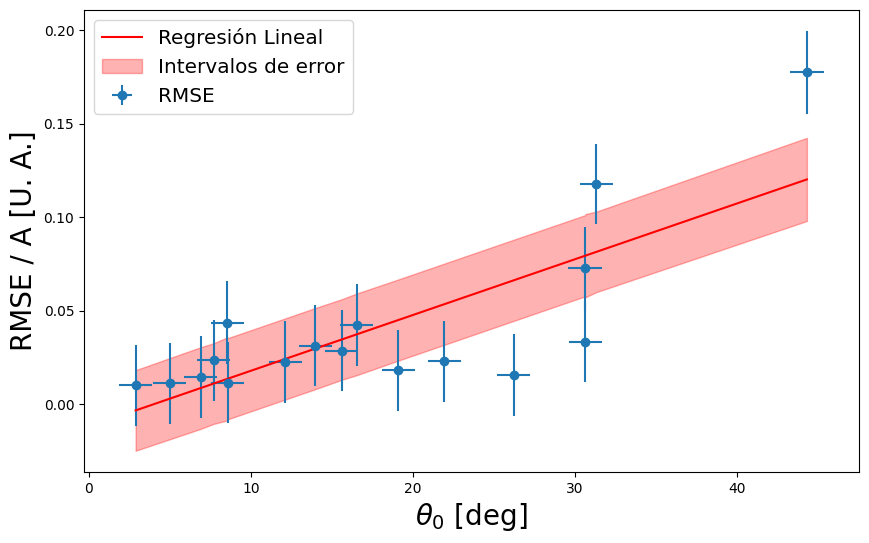

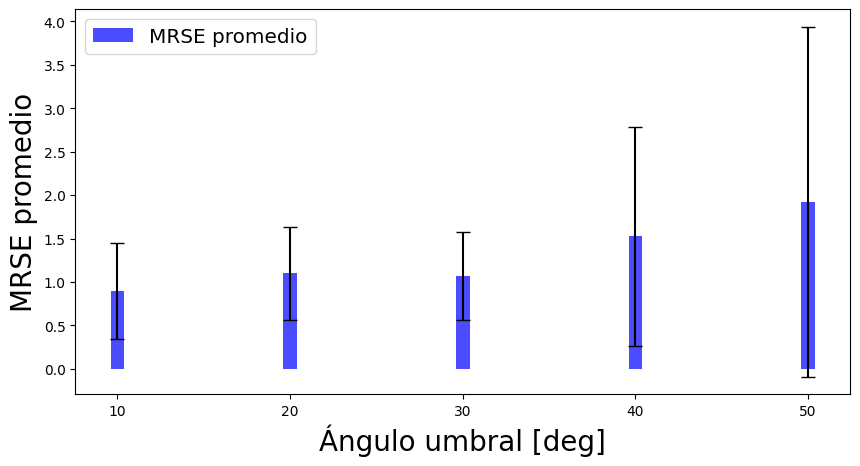

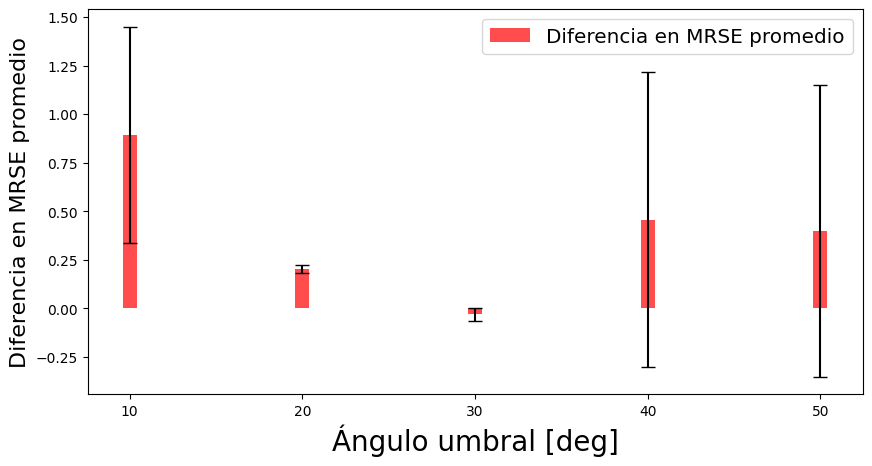

In [ ]:
def plot_approximation(data, tita0, amplitud, frecuencia, periodo, L):
    dicc = gen_dicc(data)
    x = data["t"]

    # Asegurarse de que tita0 y amplitud están en radianes
    tita0_rad = np.deg2rad(tita0)
    amplitud_rad = np.deg2rad(amplitud)

    delta = np.arcsin(tita0_rad / amplitud_rad)
    
    # Obtener las incertidumbres en tita0 y amplitud (convertidas a radianes)
    sigma_tita0 = np.deg2rad(dicc.get("dθ0", 0))
    sigma_amplitud = np.deg2rad(dicc.get("dA", 0))

    # Calcular el error en el desfase delta
    r = tita0_rad / amplitud_rad
    sqrt_term = np.sqrt(1 - r**2)
    
    # Evitar división por cero
    if sqrt_term == 0:
        print("Error: sqrt_term es cero, no se puede calcular la incertidumbre en delta.")
        sigma_delta = 0
    else:
        # Derivadas parciales
        ddelta_dtita0 = 1 / (amplitud_rad * sqrt_term)
        ddelta_damplitud = -tita0_rad / (amplitud_rad**2 * sqrt_term)

        # Calcular la incertidumbre en delta
        sigma_delta = np.sqrt( (ddelta_dtita0 * sigma_tita0)**2 + (ddelta_damplitud * sigma_amplitud)**2 )

    print("Periodo teo: ", 1 / frecuencia)
    print("Periodo calculado", periodo)
    
    periodo_teo = 2 * np.pi * np.sqrt(L / 9.32)

    y = amplitud * np.sin( 2 * np.pi * (-frecuencia) * x + delta)

    # Obtener la incertidumbre en el período estimado
    sigma_T = dicc.get("sigma_T", 0)
    
    diferencia = periodo_teo - periodo
    incertidumbre = np.sqrt((sigma_T)**2)
    
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    plt.plot(x, y, color="red", label=r'Aproximación Teórica')  # Señal teórica
    plt.plot(x, data["θr"], color="blue", label=r'Observación')  # Señal observada
    
    y_izq = amplitud * np.sin(2 * np.pi * (-frecuencia) * (x - dicc["dt"]) + delta - sigma_delta) - dicc["dθr"]
    y_der = amplitud * np.sin(2 * np.pi * (-frecuencia) * (x + dicc["dt"]) + delta + sigma_delta) + dicc["dθr"]
    plt.fill_between(x, 
                     y_izq,
                     y_der,
                     color="red", alpha=0.3, label=r'Intervalo de error')
    plt.xlabel(r'$t$ [s]', fontsize=14)
    plt.ylabel(r'$\theta$ [deg]', fontsize=14)
    plt.legend(loc='upper right', fontsize='large')
    plt.show()


def calculate_theoretical_signal(data, tita0, amplitud, frecuencia, T):
    x = data["t"]
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
    return y

def load_datasets(input_dir):
    datasets = []
    for folder in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):
                    datasets.append(os.path.join(folder, file))
    return datasets

def process_dataset(dataset_path):
    data = pd.read_csv(dataset_path)
    L = get_largo(data)
    data = format_pd(data)
    # plot_data(data)
    tita0, amplitud, T, frecuencia = get_tita0(data), get_amplitud(data), get_periodo(data), get_frecuencia(data)
    return data, tita0, amplitud, T, frecuencia, L

def plot_MSE(data, theoretical_signal):
    try:
        squared_error = (data['θr'] - theoretical_signal) ** 2
    except KeyError:
        squared_error = (data['θ'] - theoretical_signal) ** 2
    
    plt.figure()
    plt.plot(data['t'], squared_error, label=r'Error Cuadrático Medio')
    plt.xlabel(r'Tiempo', fontsize=20)
    plt.ylabel(r'Error Cuadrático Medio', fontsize=20)
    plt.legend()
    plt.show()

def plot_cumulative_error(data, theoretical_signal):
    try:
        absolute_error = np.abs(data['θr'] - theoretical_signal)
    except KeyError:
        print(data)
        absolute_error = np.abs(data['θ'] - theoretical_signal)
    
    cumulative_error = np.cumsum(absolute_error)
    
    plt.figure()
    plt.plot(data['t'], cumulative_error, label=r'Error Absoluto Acumulativo')
    plt.xlabel(r'Tiempo')
    plt.ylabel(r'Error Absoluto Acumulativo')
    plt.legend()
    #plt.title('Error Absoluto Acumulativo en el Tiempo')
    plt.show()

def graph_MRSEs(MRSEs, amplitud):
    MRSEs = sorted(MRSEs, key=lambda x: x[0])
    tita0_values = [x[0] for x in MRSEs]
    MRSE_values = [x[1] for x in MRSEs]
    tita0_errors = [x[2] for x in MRSEs]
    MRSE_errors = [x[3] for x in MRSEs]
    # printear el mrse asociado al angulo
    
    L_values = [x[4] for x in MRSEs]

    tita0_values_normalized = tita0_values
    tita0_errors_normalized = tita0_errors
    MRSE_values_normalized = [m / amplitud for m in MRSE_values]
    MRSE_errors_normalized = [e / amplitud for e in MRSE_errors]

    plt.figure(figsize=(10, 6)) 

    # Plotting MRSE with error bars
    plt.errorbar(tita0_values_normalized, MRSE_values_normalized, xerr=tita0_errors_normalized, yerr=MRSE_errors_normalized, fmt='o', label=r'RMSE')
    
    # Performing linear regression
    X = np.array(tita0_values_normalized).reshape(-1, 1)
    y = np.array(MRSE_values_normalized)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Plotting the linear regression line
    plt.plot(tita0_values_normalized, y_pred, color='red', label=r'Regresión Lineal')
    plt.fill_between(tita0_values_normalized, y_pred - MRSE_errors_normalized, y_pred + MRSE_errors_normalized, color='red', alpha=0.3, label=r'Intervalos de error')
    plt.xlabel(r'$\theta_0$ [deg]', fontsize=20)
    plt.ylabel(r'RMSE / A [U. A.]', fontsize=20)    
    plt.legend(fontsize='x-large')
    plt.show()

# Definir función para calcular el RMSE
def calculate_rmse(y, y_hat):
    n = len(y)
    rmse = np.sqrt(np.sum((y - y_hat)**2) / n)
    return rmse

# Definir función para la propagación de errores
def calculate_rmse_propagation(y, y_hat, sigma_y_hat, sigma_y=0):
    n = len(y)
    rmse = calculate_rmse(y, y_hat)
    
    # Calcular la propagación de errores
    propagation = np.sqrt(np.sum(((y - y_hat)**2) * (sigma_y**2 + sigma_y_hat**2)) / (n * rmse**2))
    
    return rmse, propagation

def analyze_threshold_effect_on_MRSE(MRSEs, amplitud):
    # Separar los MRSE en dos partes: menor o igual a 18 grados y mayor a 18 grados
    threshold = 29

    lower_values = [mrse for mrse in MRSEs if mrse[0] <= threshold]
    higher_values = [mrse for mrse in MRSEs if mrse[0] > threshold]

    # Calcular el promedio y desviación estándar del MRSE para cada parte
    lower_MRSEs = np.array([mrse[1] for mrse in lower_values])
    higher_MRSEs = np.array([mrse[1] for mrse in higher_values])

    # Promedio y desviación estándar
    lower_mean = lower_MRSEs.mean() if len(lower_MRSEs) > 0 else None
    lower_std = lower_MRSEs.std() if len(lower_MRSEs) > 0 else None
    higher_mean = higher_MRSEs.mean() if len(higher_MRSEs) > 0 else None
    higher_std = higher_MRSEs.std() if len(higher_MRSEs) > 0 else None

    # Mostrar resultados del análisis
    print(f"Ángulos menores o iguales a {threshold} grados:")
    if lower_mean is not None:
        print(f"  MRSE promedio: {lower_mean:.2f} ± {lower_std:.2f}")
    else:
        print("  No hay datos en este rango.")

    print(f"Ángulos mayores a {threshold} grados:")
    if higher_mean is not None:
        print(f"  MRSE promedio: {higher_mean:.2f} ± {higher_std:.2f}")
    else:
        print("  No hay datos en este rango.")
    
    # Diferencia en amplitud esperada con base en el MRSE promedio
    if lower_mean is not None and higher_mean is not None:
        print(f"\nLa diferencia en MRSE entre los dos segmentos es de aproximadamente: {higher_mean - lower_mean:.2f}")
        print(f"Esto indica que, para ángulos mayores a {threshold} grados, el error se incrementa en comparación con ángulos menores.")

def plot_MRSE_analysis(MRSEs, amplitud):
    angles = range(0, 55, 10)
    means = []
    stds = []

    for threshold in angles:
        lower_values = [mrse for mrse in MRSEs if mrse[0] <= threshold]
        lower_MRSEs = np.array([mrse[1] for mrse in lower_values])
        mean = lower_MRSEs.mean() if len(lower_MRSEs) > 0 else 0
        std = lower_MRSEs.std() if len(lower_MRSEs) > 0 else 0
        means.append(mean)
        stds.append(std)

    plt.figure(figsize=(10, 5))
    plt.bar(angles[1:], means[1:], yerr=stds[1:], capsize=5, alpha=0.7, color='b', label='MRSE promedio')
    plt.xticks(range(10, 55, 10))  # Cambia los xticks para que vayan de 10 en 10
    plt.legend(fontsize='x-large')
    plt.xlabel('Ángulo umbral [deg]', fontsize=20)
    plt.ylabel('MRSE promedio', fontsize=20)
    plt.show()

    differences = np.diff(means)
    differences_stds = np.sqrt(np.diff(stds)**2)

    plt.figure(figsize=(10, 5))
    plt.bar(angles[1:], differences, yerr=differences_stds,capsize= 5 ,alpha=0.7, color='r', label='Diferencia en MRSE promedio')
    plt.legend(fontsize='x-large')
    plt.xlabel('Ángulo umbral [deg]', fontsize=20)
    plt.ylabel('Diferencia en MRSE promedio', fontsize=16)
    plt.xticks(angles[1:])  # Set x-axis ticks to start from 10 degrees
    plt.show()

def analyze_period_vs_estimate(MRSEs, datasets_info):
    # Separar los datos según el umbral de 18 grados
    threshold = 30

    # Listas para almacenar las diferencias de los periodos calculados vs estimados
    period_diffs_below_threshold = []
    period_diffs_above_threshold = []

    # Recorrer la información de los conjuntos de datos y los MRSE
    for i, (tita0, MRSE, dtheta, dMRSE, L, amplitud) in enumerate(MRSEs):
        if i >= len(datasets_info):
            break
        period_calculated = datasets_info[i]["period_calculated"]
        period_theoretical = datasets_info[i]["period_theoretical"]
        period_diff = period_calculated - period_theoretical

        if tita0 <= threshold:
            period_diffs_below_threshold.append(period_diff)
        else:
            period_diffs_above_threshold.append(period_diff)

    # Convertir a arrays de numpy para calcular estadísticas
    period_diffs_below_threshold = np.array(period_diffs_below_threshold)
    period_diffs_above_threshold = np.array(period_diffs_above_threshold)

    # Calcular estadísticas para los períodos
    below_mean = np.mean(period_diffs_below_threshold) if len(period_diffs_below_threshold) > 0 else None
    below_std = np.std(period_diffs_below_threshold) if len(period_diffs_below_threshold) > 0 else None
    above_mean = np.mean(period_diffs_above_threshold) if len(period_diffs_above_threshold) > 0 else None
    above_std = np.std(period_diffs_above_threshold) if len(period_diffs_above_threshold) > 0 else None

    # Mostrar resultados del análisis de períodos
    print(f"Períodos para ángulos menores o iguales a {threshold} grados:")
    if below_mean is not None:
        print(f"  Diferencia promedio (calculado - teórico): {below_mean:.4f} ± {below_std:.4f}")
    else:
        print("  No hay datos en este rango.")

    print(f"Períodos para ángulos mayores a {threshold} grados:")
    if above_mean is not None:
        print(f"  Diferencia promedio (calculado - teórico): {above_mean:.4f} ± {above_std:.4f}")
    else:
        print("  No hay datos en este rango.")
    
    # Gráficas de las diferencias de período
    plt.figure(figsize=(10, 6))
    plt.hist(period_diffs_below_threshold, bins=10, alpha=0.5, label=f'Ángulos ≤ {threshold} grados', color='b')
    plt.hist(period_diffs_above_threshold, bins=10, alpha=0.5, label=f'Ángulos > {threshold} grados', color='r')
    plt.xlabel('Diferencia de Período (Calculado - Teórico) [s]', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.legend(loc='upper right')
    plt.title('Distribución de la Diferencia de Período', fontsize=16)
    plt.grid(True)
    plt.show()


def graphs():
    input_dir = os.path.join('..', 'datasets')
    datasets = load_datasets(input_dir)
    
    MRSEs_tita0 = []
    datasets_info = []
     
    for i, dataset in enumerate(datasets):
        # print(f"{i}: {dataset}")
        dataset_path = os.path.join(input_dir, dataset)
        data, tita0, amplitud, T, frecuencia, L = process_dataset(dataset_path)

        dicc = gen_dicc(data)

        # plot_approximation(data, tita0=tita0, amplitud=amplitud, frecuencia=frecuencia, periodo=T, L = L)
        
        theoretical_signal = calculate_theoretical_signal(data, tita0, amplitud, frecuencia, T)
        MRSE, dMRSE = calculate_rmse_propagation(data['θr'], theoretical_signal, dicc["dθr"])
        if 23.5 < tita0 < 24.5:
            continue

        # Conversión de unidades y uso del valor correcto de g
        g = 9.81  # Aceleración de la gravedad en m/s²
        L_metros = L / 100  # Convertir L de cm a metros

        period_theoretical = 2 * np.pi * np.sqrt(L_metros / g)
        period_calculated = T


        MRSEs_tita0.append((tita0, MRSE, dicc["dθ0"], dMRSE, L, amplitud))
        # plot_MSE(data, theoretical_signal)
        # plot_cumulative_error(data, theoretical_signal)
                
        datasets_info.append({
            "tita0": tita0,
            "period_calculated": period_calculated,
            "period_theoretical": period_theoretical,
        })

    graph_MRSEs(MRSEs_tita0, amplitud)
    analyze_threshold_effect_on_MRSE(MRSEs_tita0, amplitud)
    plot_MRSE_analysis(MRSEs_tita0)
    # analyze_period_vs_estimate(MRSEs_tita0, datasets_info)


graphs()


El momento en el que ocurre la mayor diferencia d error en funcion de los angulos que un elige, es cuando pasas de mirar angulos menores a 25 grados y empezas a mirar angulos menores a 30 grados. Esto quiere decir, que, los angulos entre 25 y 30 grados, tienen una difrencia de error significativa (y mesurable) con los anteriores.
Por ello se elijió este punto como threshold. Además, en el otro grafico, se puede ver como la varianza aumenta a medida que miras mas angulos. Esto, junto al aumento en la media, quiere decir que a angulos mayores, el RMSE es mayor.


CUANTFICAR LOS RMSE VARIANZAS Y MEDIAS